<div style="display: flex; flex-direction: row; align-items: center;">
    <div style="flex: 0; margin-top: 8px;">
        <img src="https://cdn.britannica.com/36/189336-050-8D1DAA2C/Obesity-body-fat-accumulation-conditions.jpg" alt="Image" style="max-width: 300px; max-height: 350px;" />
    </div>
    <div style="flex: 1; margin-left: 30px; margin-top: 6px">
      <p style="font-weight: bold; color: black; font-size: 17px">Introduction</p>
      <p>In this notebook I am going to apply the <b>ANN Model</b> on the Multi-Class Prediction of Obesity Risk Dataset along with the <b>EDA</b>, <b>Feature Engineering</b> and <b>HyperParameter Tuning</b>.</p>
     <p>If you find this notebook helpful, your <b>upvote</b> would be greatly appreciated.</p>
     </div>
</div>

Importing the Basic Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings(action='ignore')
import missingno
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf 
import keras_tuner as kt
import shap

2024-02-16 05:32:58.232396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 05:32:58.232566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 05:32:58.409177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Importing the Dataset

About the Data

Frequent consumption of high caloric food (FAVC)

Frequency of consumption of vegetables (FCVC)

Number of main meals (NCP)

Consumption of food between meals (CAEC)

Person Smoking Habit(SMOKER OR NOT) (SMOKE)

Consumption of water daily (CH20)

Calories consumption monitoring (SCC)

Physical activity frequency (FAF)

Time using technology devices (TUE)

Consumption of alcohol (CALC)

Transportation used (MTRANS)

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
org_data = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

In [3]:
id = test['id'] # saving the id column for the submission file 
train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

In [4]:
train.shape, org_data.shape, test.shape

((20758, 17), (2111, 17), (13840, 16))

# 2. EDA

Cheking for the null values 

<Axes: >

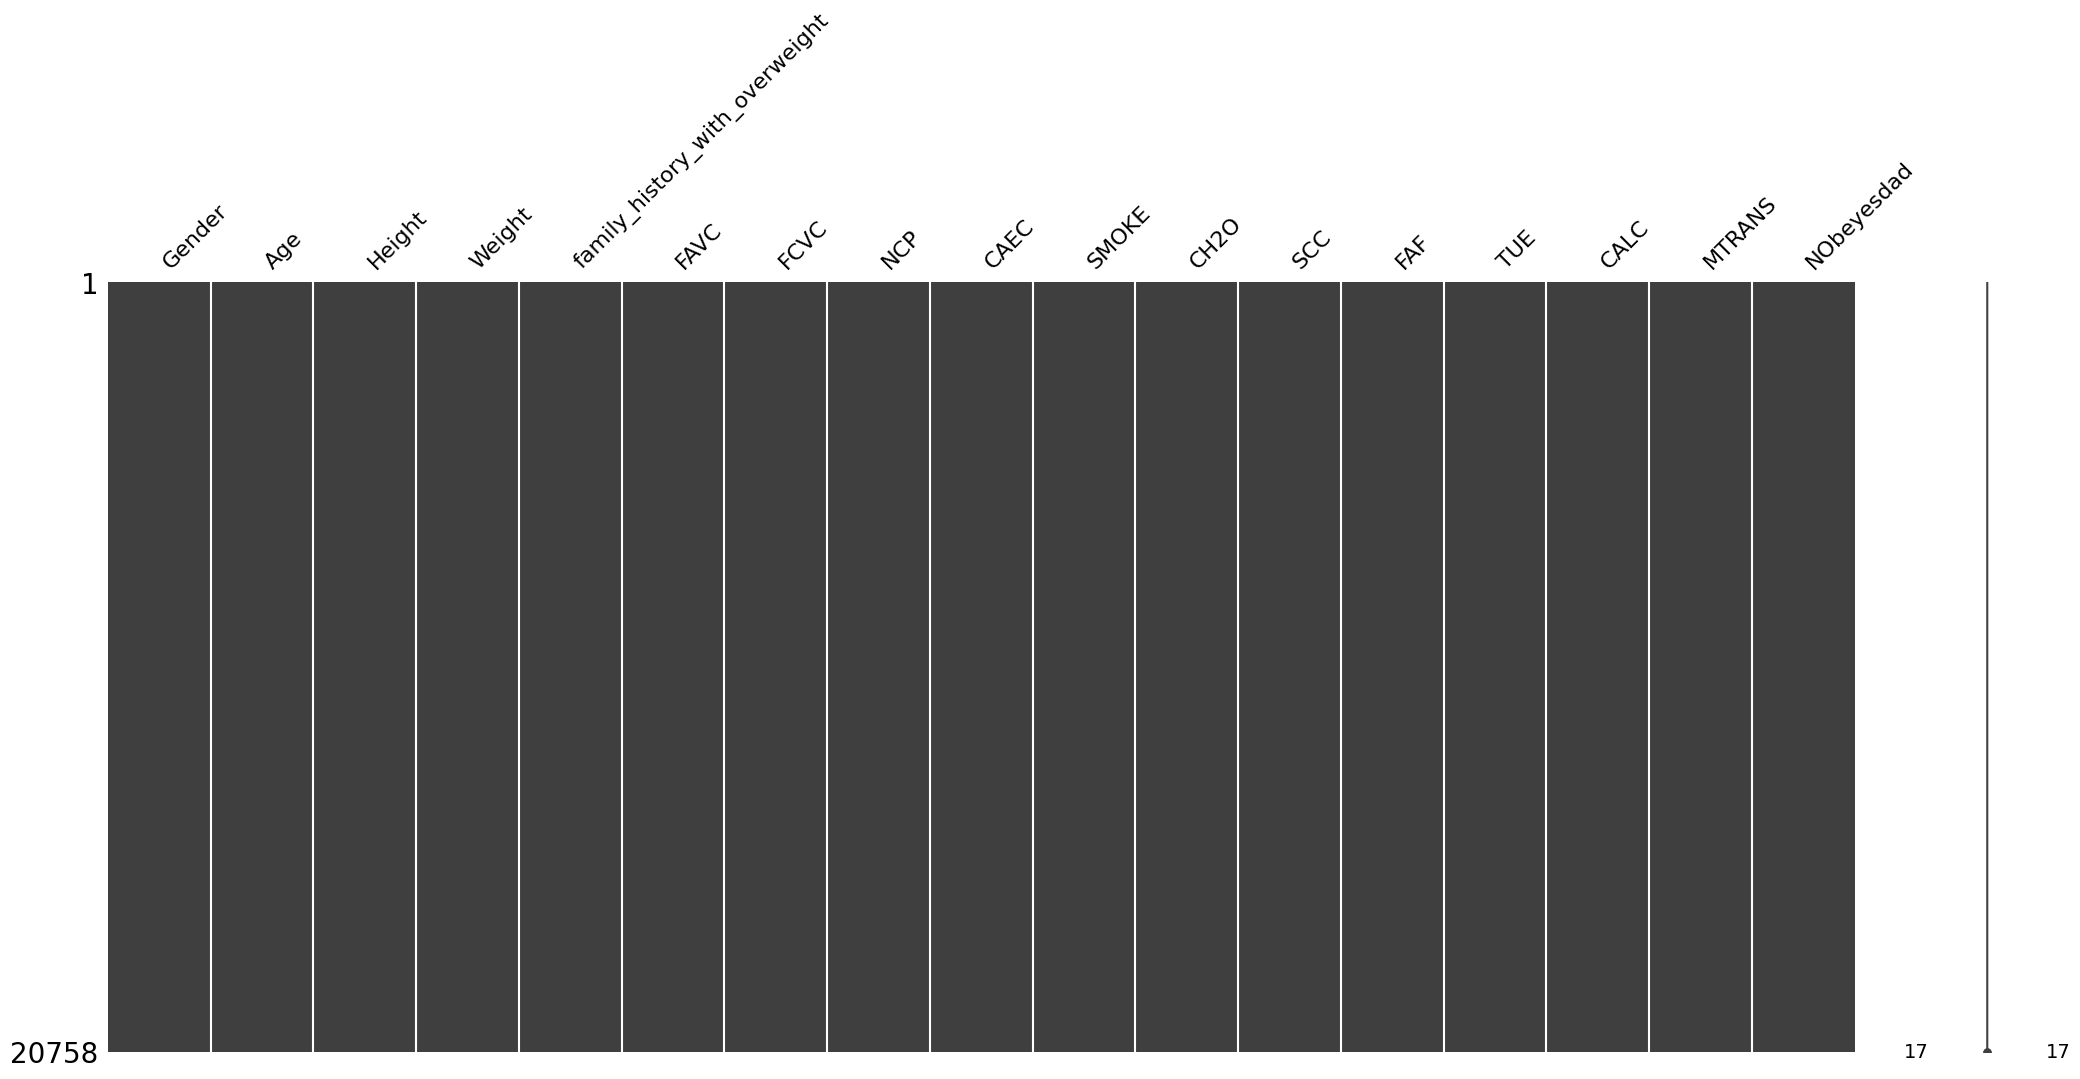

In [5]:
missingno.matrix(train)

<Axes: >

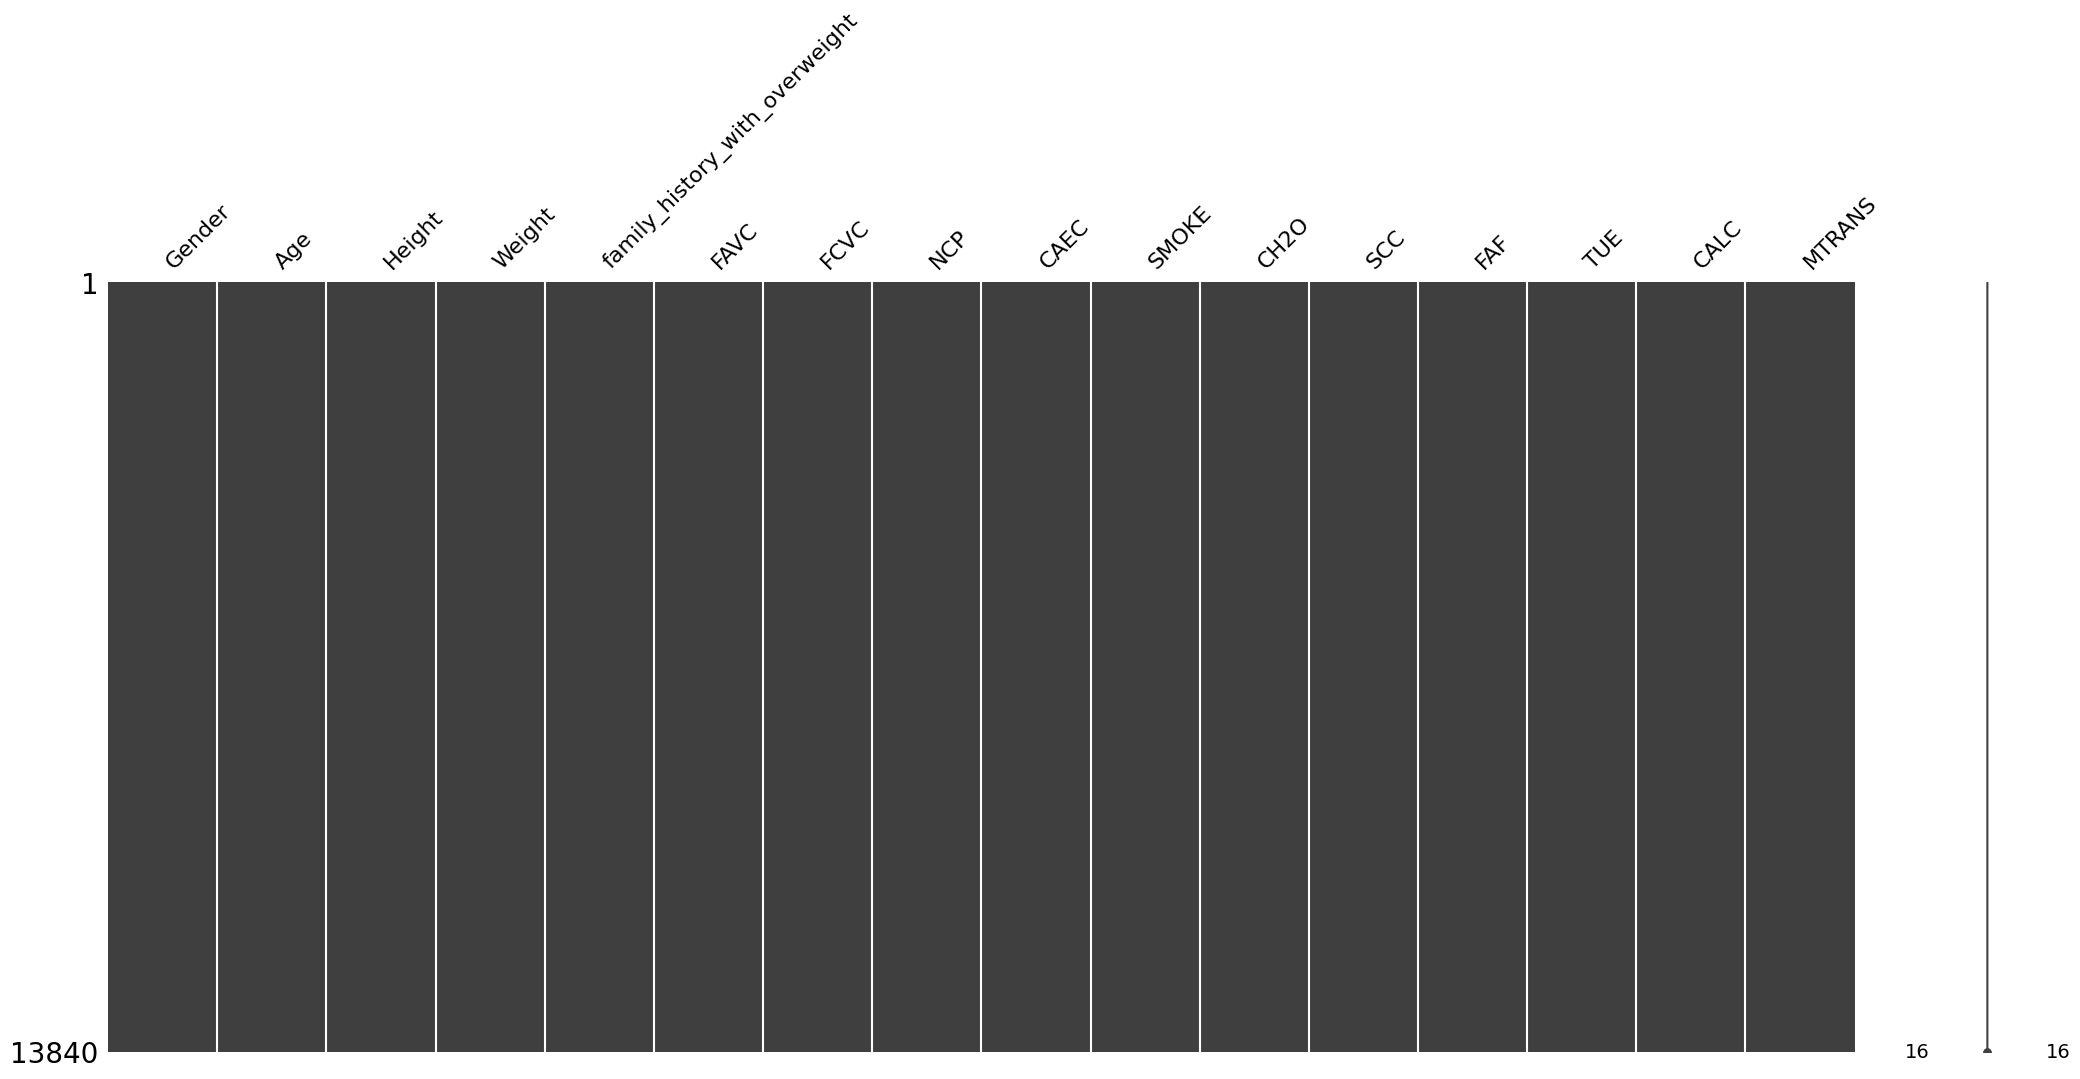

In [6]:
missingno.matrix(test)

<Axes: >

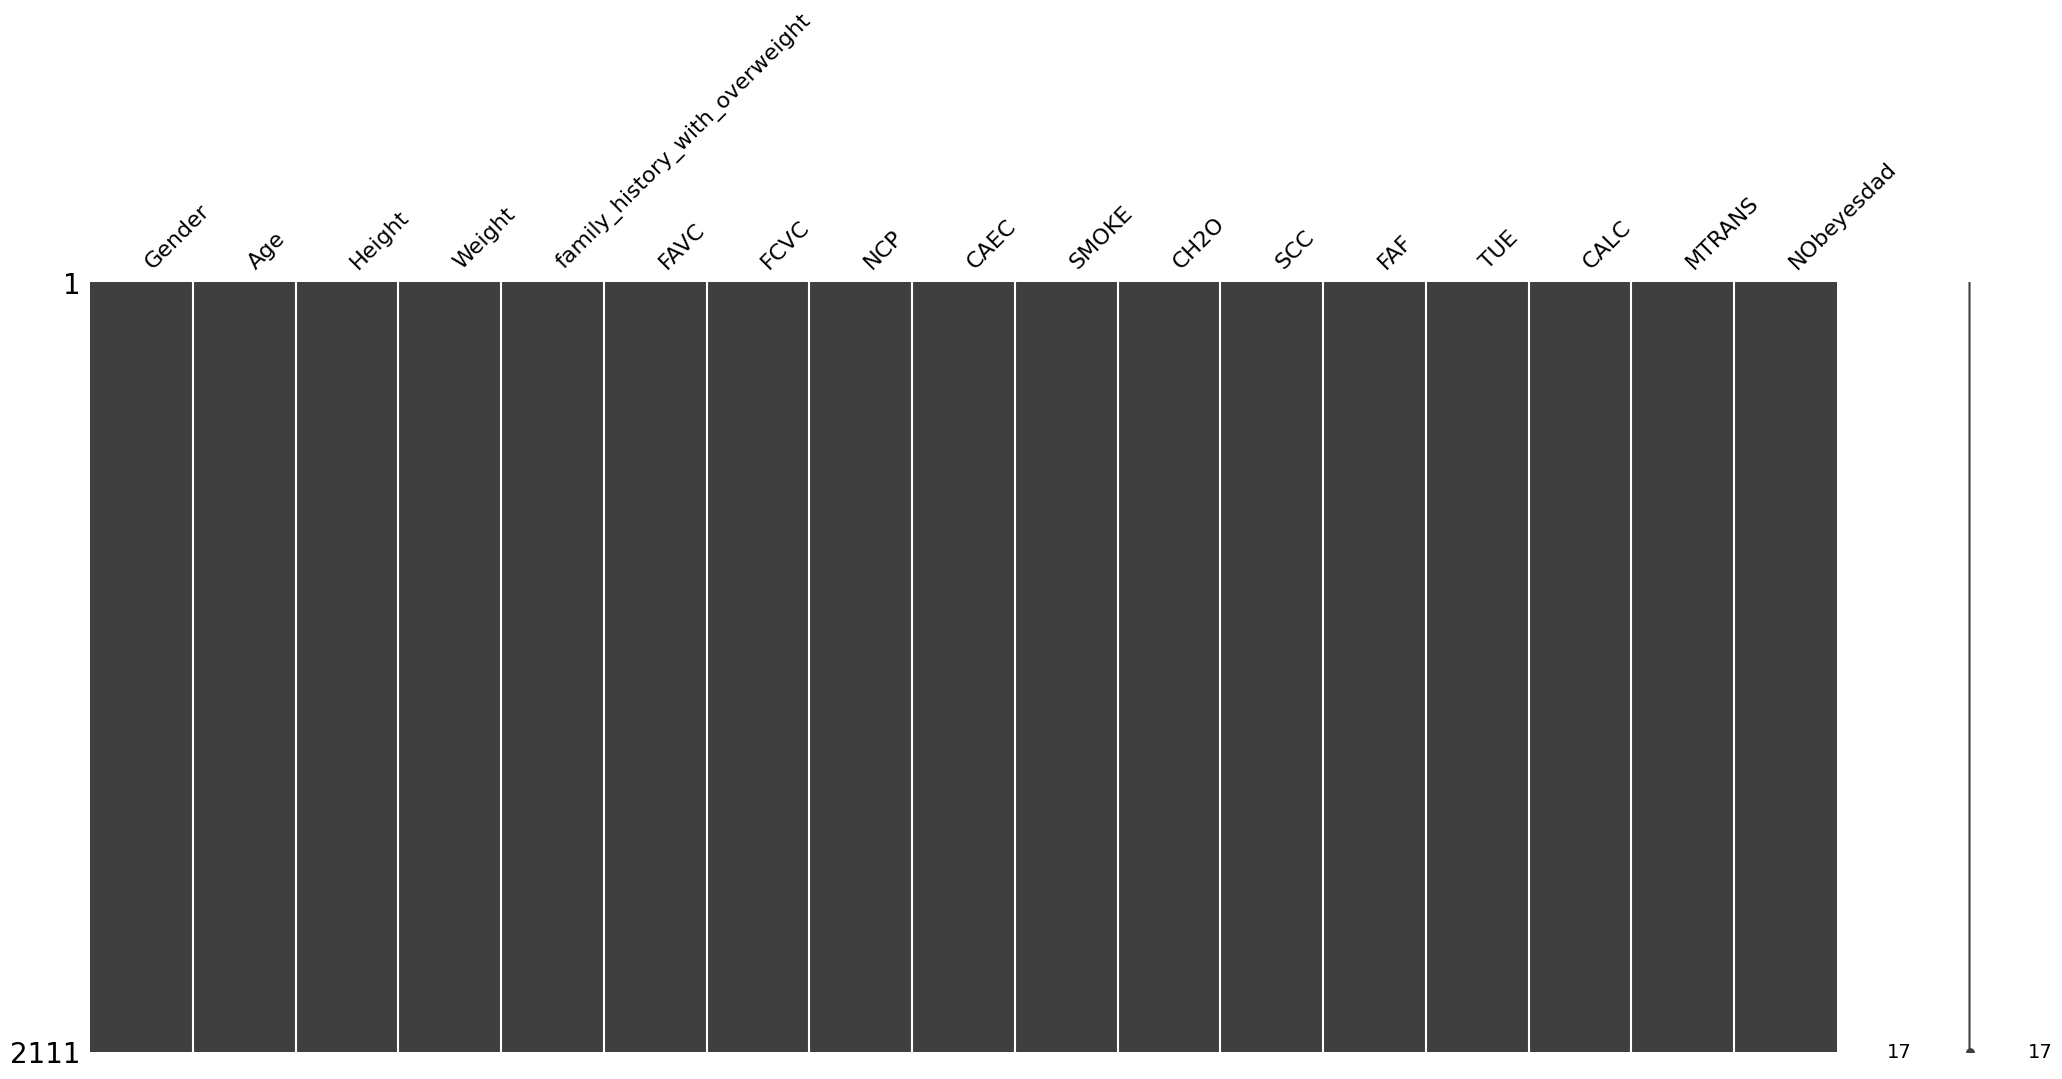

In [7]:
missingno.matrix(org_data)

In [8]:
train.isnull().sum().sum(), org_data.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0, 0)

Checking for Duplicated Values

In [9]:
train.duplicated().sum(), test.duplicated().sum(), org_data.duplicated().sum()

(0, 0, 24)

We have duplicate values in the original data and we will remove it.

In [10]:
org_data.drop_duplicates(keep='first', inplace = True)

No null values and no duplicated values 

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [12]:
train.describe().T.style.background_gradient(cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
Age,20758.000000,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.000000,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.000000,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.000000,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.000000,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.000000,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.000000,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.000000,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          13840 non-null  object 
 1   Age                             13840 non-null  float64
 2   Height                          13840 non-null  float64
 3   Weight                          13840 non-null  float64
 4   family_history_with_overweight  13840 non-null  object 
 5   FAVC                            13840 non-null  object 
 6   FCVC                            13840 non-null  float64
 7   NCP                             13840 non-null  float64
 8   CAEC                            13840 non-null  object 
 9   SMOKE                           13840 non-null  object 
 10  CH2O                            13840 non-null  float64
 11  SCC                             13840 non-null  object 
 12  FAF                             

In [14]:
test.describe().T.style.background_gradient(cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
Age,13840.000000,23.952740,5.799814,14.000000,20.000000,22.906342,26.000000,61.000000
Height,13840.000000,1.698934,0.088761,1.450000,1.631662,1.700000,1.760710,1.980000
Weight,13840.000000,87.384504,26.111819,39.000000,65.000000,83.952968,111.157811,165.057269
FCVC,13840.000000,2.442898,0.531606,1.000000,2.000000,2.358087,3.000000,3.000000
NCP,13840.000000,2.750610,0.710927,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,13840.000000,2.032044,0.611230,1.000000,1.771781,2.000000,2.552388,3.000000
FAF,13840.000000,0.974532,0.840361,0.000000,0.001086,1.000000,1.571865,3.000000
TUE,13840.000000,0.611033,0.608005,0.000000,0.000000,0.552498,1.000000,2.000000


In [15]:
# categorical columns 
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC','CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
# numerical columns 
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [16]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

Categorical Variable Analysis

Number of instances for each unique value in column Gender:
Gender
Female    10422
Male      10336
Name: count, dtype: int64


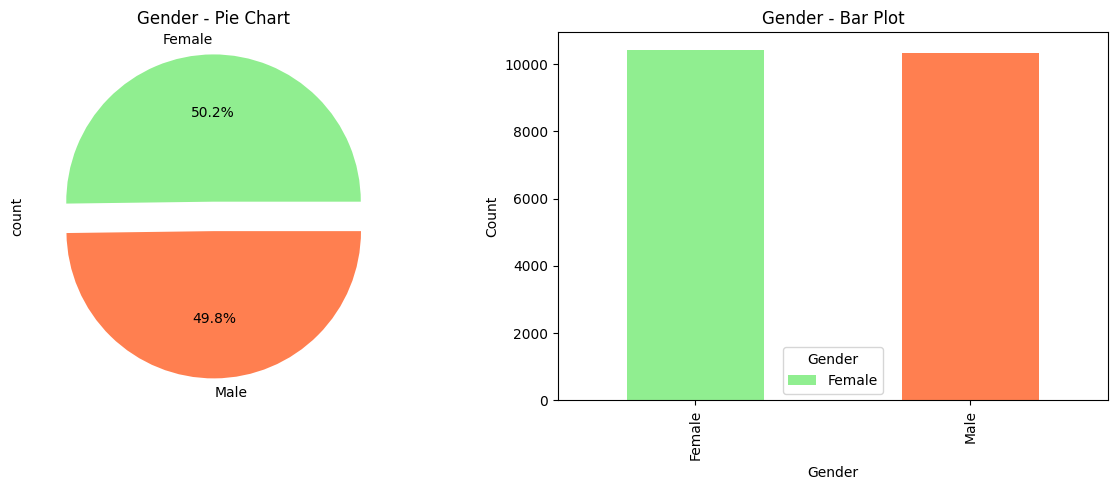

Number of instances for each unique value in column family_history_with_overweight:
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64


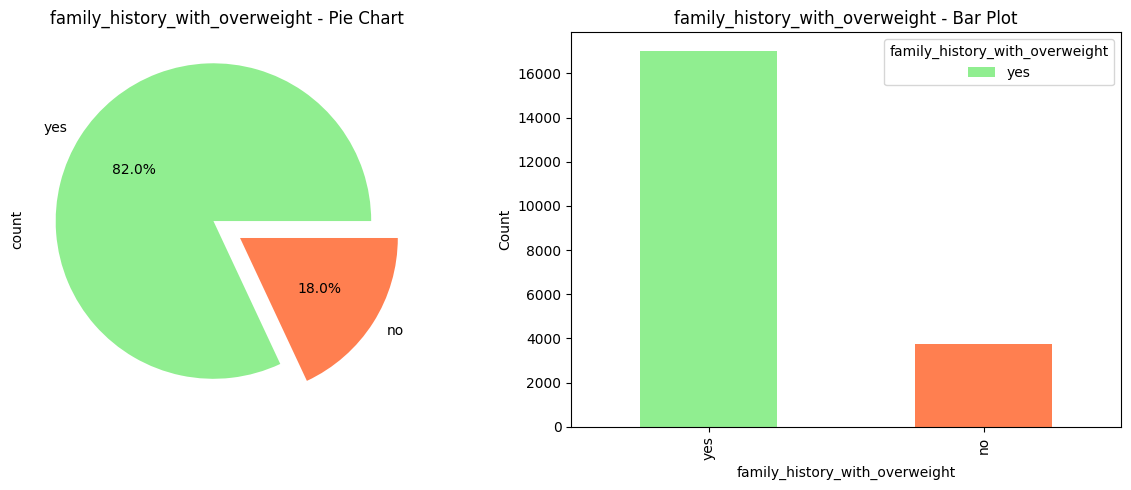

Number of instances for each unique value in column FAVC:
FAVC
yes    18982
no      1776
Name: count, dtype: int64


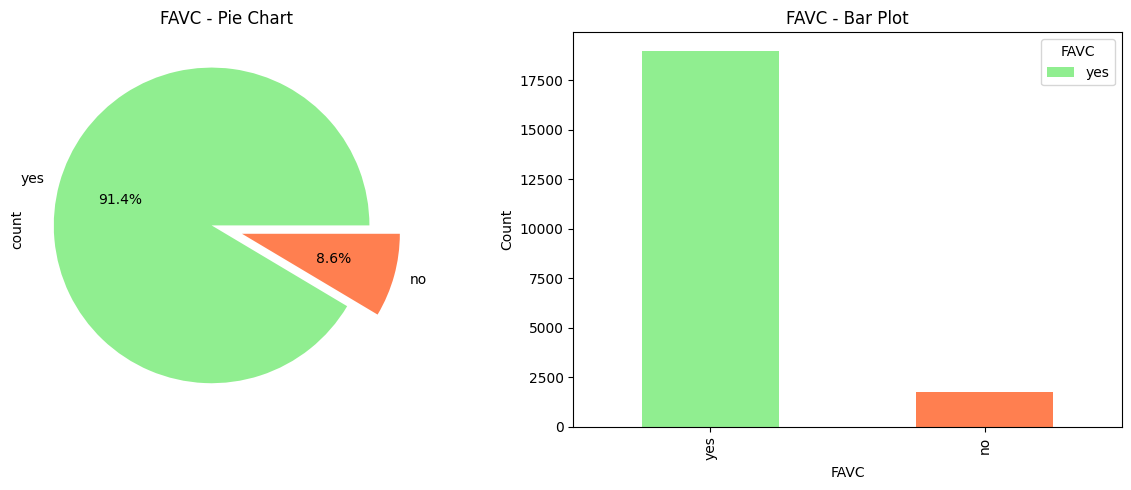

Number of instances for each unique value in column CAEC:
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64


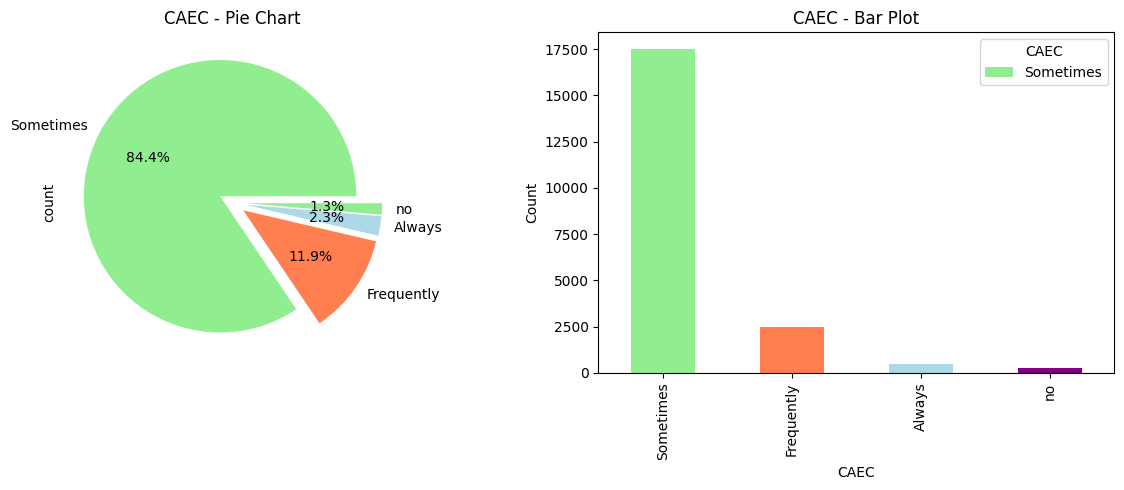

Number of instances for each unique value in column SMOKE:
SMOKE
no     20513
yes      245
Name: count, dtype: int64


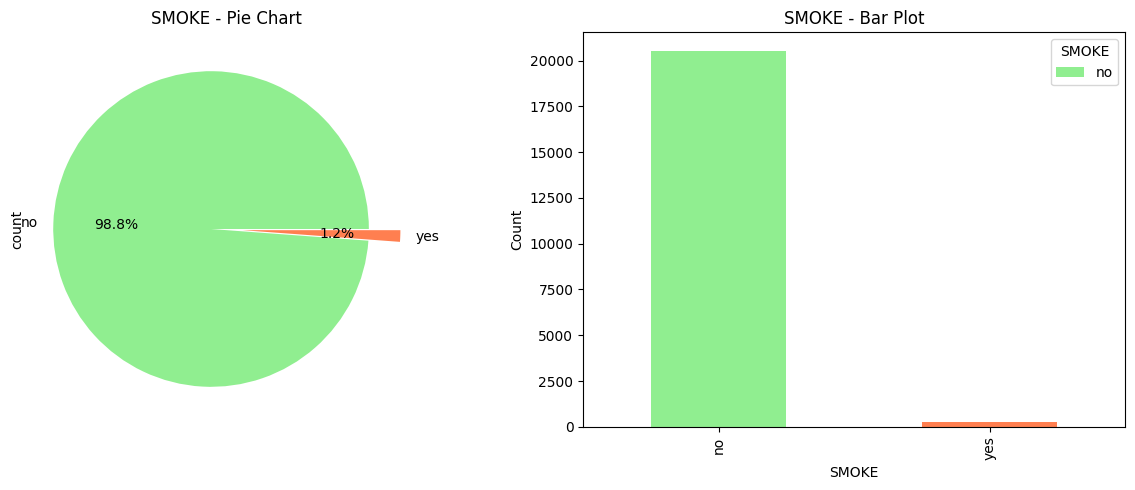

Number of instances for each unique value in column SCC:
SCC
no     20071
yes      687
Name: count, dtype: int64


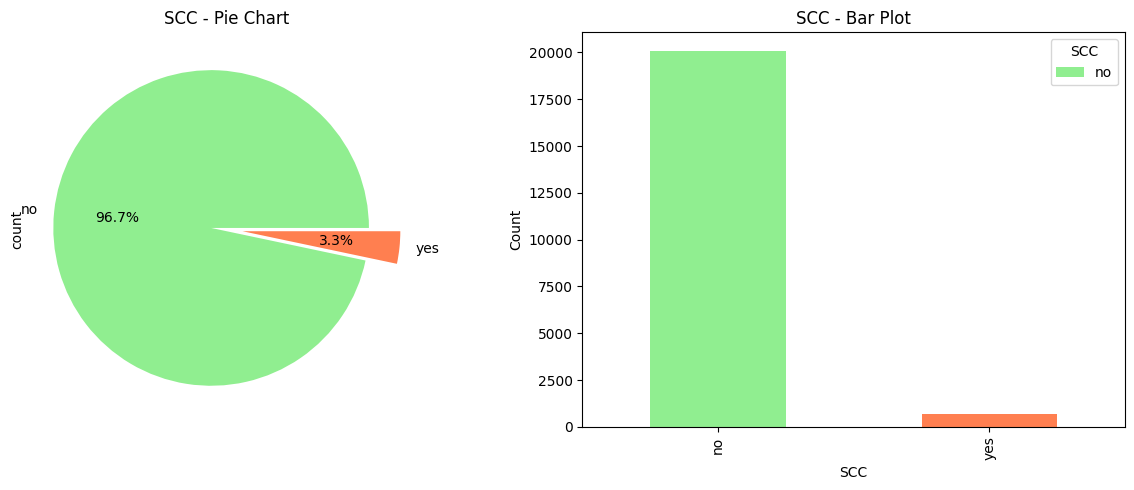

Number of instances for each unique value in column CALC:
CALC
Sometimes     15066
no             5163
Frequently      529
Name: count, dtype: int64


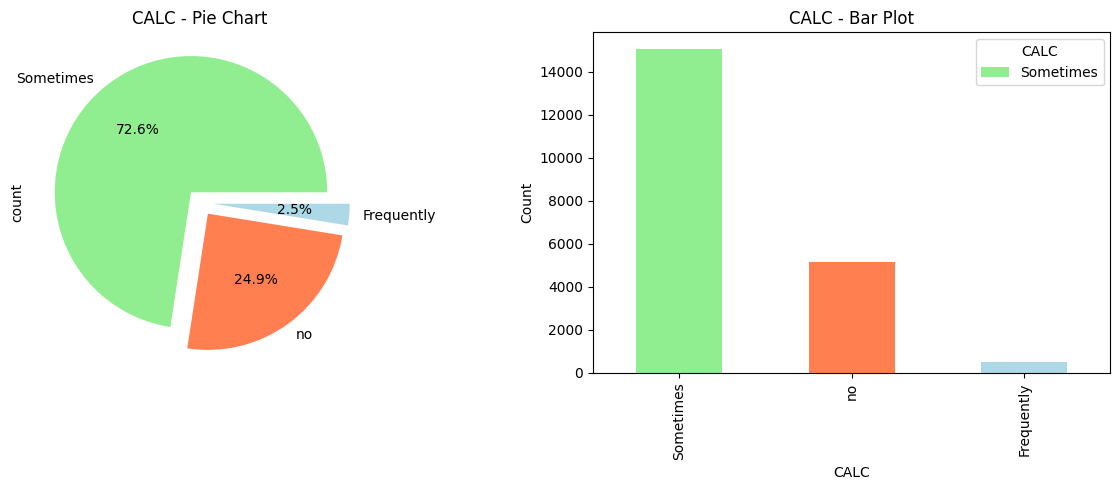

Number of instances for each unique value in column MTRANS:
MTRANS
Public_Transportation    16687
Automobile                3534
Walking                    467
Motorbike                   38
Bike                        32
Name: count, dtype: int64


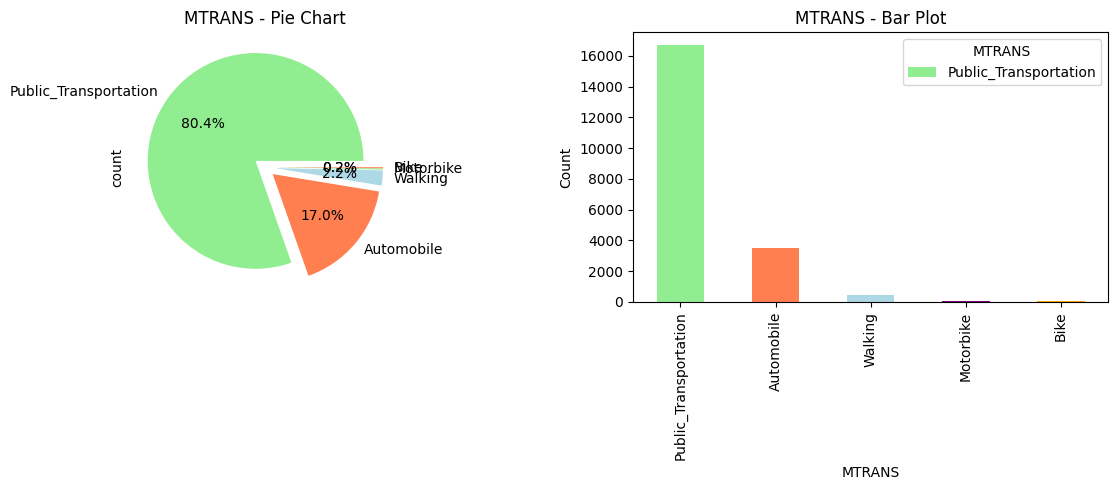

In [17]:
# Define colors for the pie chart and bar plot
pie_colors = ['lightgreen', 'coral', 'lightblue']  # Define colors for pie chart slices
bar_colors = ['lightgreen', 'coral', 'lightblue', 'purple', 'orange', 'red', 'salmon']  # Define colors for bar plot bars

# Plot pie chart and bar plot for each categorical column
for col in cat_cols:
    # Count the instances of each unique value in the column
    value_counts = X[col].value_counts()
    
    # Print the counts of each unique value
    print(f'Number of instances for each unique value in column {col}:')
    print(value_counts)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart
    value_counts.plot(kind='pie', autopct='%1.1f%%', ax=axes[0], colors=pie_colors, explode=[0.1] * len(value_counts))
    axes[0].set_title(f'{col} - Pie Chart')
    
    # Bar plot
    value_counts.plot(kind='bar', ax=axes[1], color=bar_colors)
    axes[1].set_title(f'{col} - Bar Plot')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Count')
    axes[1].legend(title=col, labels=value_counts.index)  # Specify all unique values as labels
    
    plt.tight_layout()
    plt.show()

Numerical Value Analysis

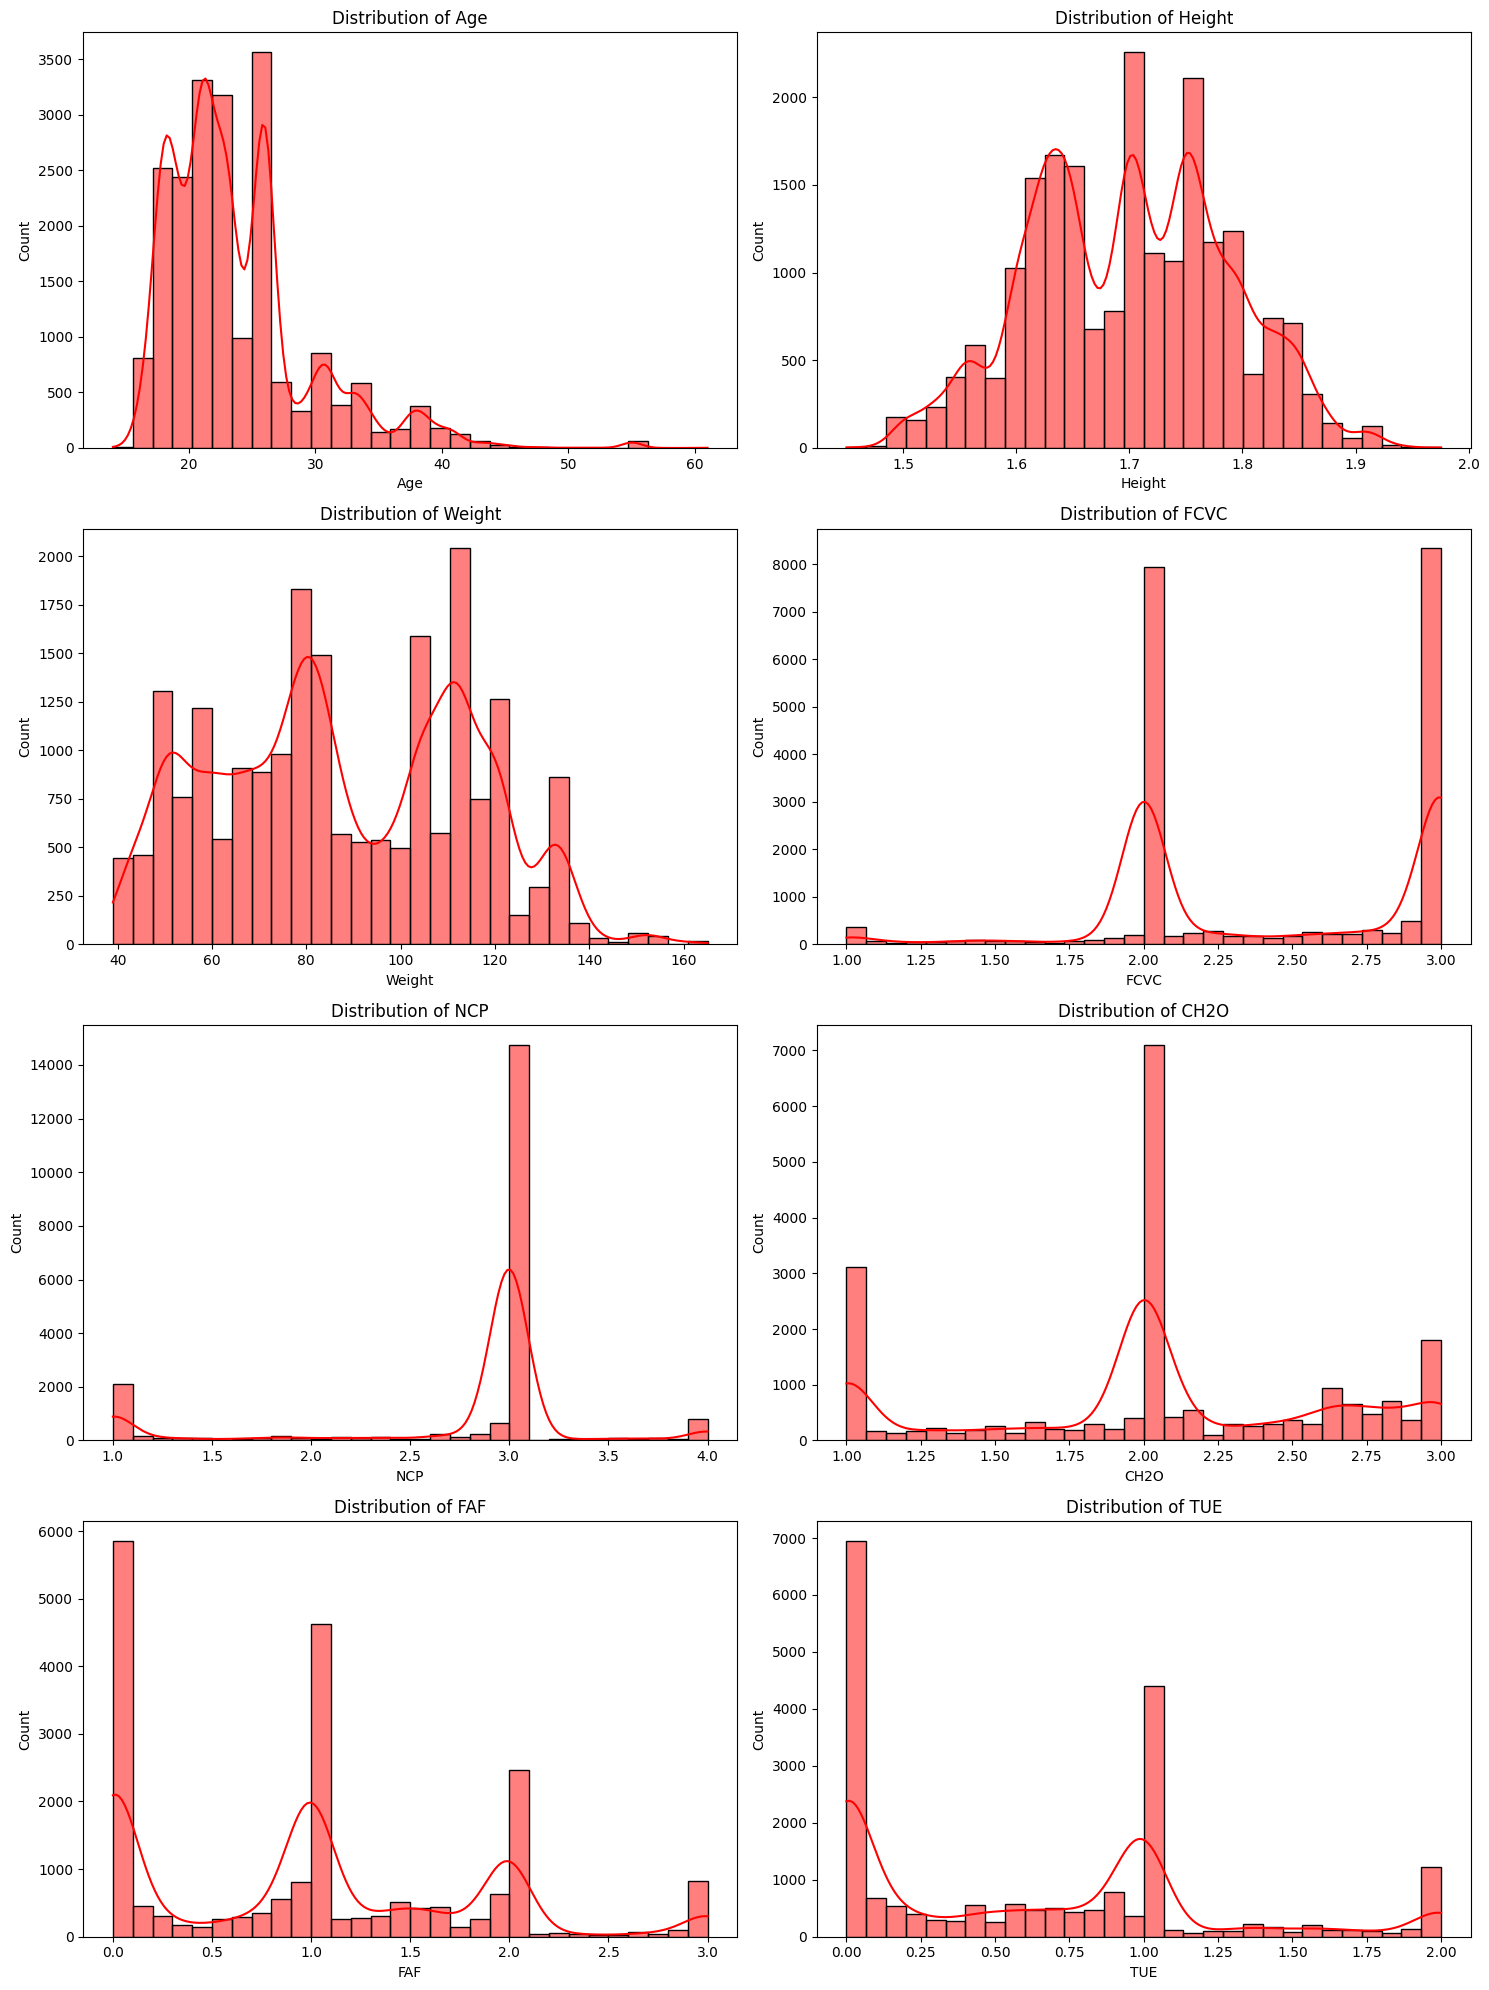

In [18]:
# Filter out the specific warning about use_inf_as_na being deprecated
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

num_rows = len(num_cols) // 2 + len(num_cols) % 2

plt.figure(figsize=(15, 5 * num_rows))
for i, column in enumerate(num_cols, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(X[column].replace([np.inf, -np.inf], np.nan).dropna(), kde=True, bins=30, color='red')  # Set color to maroon
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

# 3. Feature Engineering 

In [19]:
cols_round = ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

X[cols_round] = X[cols_round].round()
X['Weight'] = X['Weight'].round(1)
X['Height'] = X['Height'].round(2)

test[cols_round] = test[cols_round].round()
test['Weight'] = test['Weight'].round(1)
test['Height'] = test['Height'].round(2)

In [20]:
X['BMI'] =  (X['Weight']/X['Height']**2).round(2)

test['BMI'] = (test['Weight']/test['Height']**2).round(2)

In [21]:
# Create bins and labels
bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III']

# Create a new column 'BMI_cat' based on the bins and labels
X['BMI_cat'] = pd.cut(X['BMI'], bins=bins, labels=labels)

# same fo the test data
test['BMI_cat'] = pd.cut(test['BMI'], bins=bins, labels=labels)

In [22]:
# Age Binning 

# Definining number of bins
n_bins = 5

# Binning the age data using quartiles
X['age_bin'] = pd.qcut(X['Age'], q=n_bins, labels=False, duplicates='drop')

test['age_bin'] = pd.qcut(test['Age'], q=n_bins, labels=False, duplicates='drop')

In [23]:
# h2o consumption Binning 

# Definining number of bins
n_bins = 3

# Binning the age data using quartiles
X['h2o_cons'] = pd.qcut(X['CH2O'], q=n_bins, labels=False, duplicates='drop')

test['h2o_cons'] = pd.qcut(test['CH2O'], q=n_bins, labels=False, duplicates='drop')

Below feature engineering steps refrences from :- https://www.kaggle.com/code/yorkyong/obesity-risk-feature-engineering-ensemble

In [24]:
# consumption of alcohol or food between meals 

X['alc_food'] = X['CAEC'] + '_' + X['CALC']

test['alc_food'] = test['CAEC'] + '_' + test['CALC']

In [25]:
# age and gender interaction

X['age_gen'] = X['Age'].round().astype('int').astype('str') + X['Gender']

test['age_gen'] = test['Age'].round().astype('int').astype('str') + test['Gender']

In [26]:
# we will add a net physical activity which will comprise of physical activities - time spent on tech devices

X['net_phy'] = X['FAF'] - X['TUE']

test['net_phy'] = test['FAF'] - test['TUE']

In [27]:
y = y.astype(str)

le = LabelEncoder()
y_transform = le.fit_transform(y)
print(y_transform)

[6 1 0 ... 3 6 3]


In [28]:
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC','CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'BMI_cat', 'alc_food', 'age_gen']

for col in cat_cols:
    X[col] = le.fit_transform(X[col])
    test[col] = le.fit_transform(test[col])
y = le.fit_transform(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [30]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# 4. ANN Model

In [31]:
def build_model(hp):
    
    model = tf.keras.Sequential()
    
    counter = 0
    for i in range(hp.Int('num_layers', min_value = 1, max_value = 10)):
        if counter == 0:
            model.add(
                tf.keras.layers.Dense(
                    hp.Int('units'+str(i), min_value = 8, max_value = 128),
                    activation = hp.Choice('activation' + str(i), values = ['relu', 'tanh', 'sigmoid']),
                    input_shape = (23,)
                )
            )
            model.add(tf.keras.layers.Dropout(hp.Choice('dropout'+str(i), values = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
            counter = 1
            
        else:             
            model.add(
                tf.keras.layers.Dense(
                    hp.Int('units'+str(i), min_value = 8, max_value = 128),
                    activation = hp.Choice('activation' + str(i), values = ['relu', 'tanh', 'sigmoid'])
                )
            )
            model.add(tf.keras.layers.Dropout(hp.Choice('dropout'+str(i), values = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        
    model.add(tf.keras.layers.Dense(7, activation='softmax'))
        
    model.compile(
        optimizer=hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd', 'nadam', 'adadelta']), 
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
        
    return model

In [32]:
tuner = kt.RandomSearch(build_model,
                        objective = 'val_accuracy',
                        max_trials = 25,
                        directory = 'mydir',
                        project_name = 'ann')

In [33]:
tuner.search(X_train, y_train, epochs = 5, validation_data = (X_test, y_test))

Trial 25 Complete [00h 00m 23s]
val_accuracy: 0.19484585523605347

Best val_accuracy So Far: 0.8547688126564026
Total elapsed time: 00h 06m 13s


In [34]:
tuner.get_best_hyperparameters()[0].values 

{'num_layers': 1,
 'units0': 93,
 'activation0': 'tanh',
 'dropout0': 0.6,
 'optimizer': 'adam',
 'units1': 48,
 'activation1': 'relu',
 'dropout1': 0.5,
 'units2': 66,
 'activation2': 'sigmoid',
 'dropout2': 0.2,
 'units3': 122,
 'activation3': 'relu',
 'dropout3': 0.9,
 'units4': 53,
 'activation4': 'tanh',
 'dropout4': 0.6,
 'units5': 114,
 'activation5': 'tanh',
 'dropout5': 0.4,
 'units6': 79,
 'activation6': 'sigmoid',
 'dropout6': 0.3,
 'units7': 91,
 'activation7': 'relu',
 'dropout7': 0.3,
 'units8': 93,
 'activation8': 'sigmoid',
 'dropout8': 0.7,
 'units9': 72,
 'activation9': 'sigmoid',
 'dropout9': 0.8}

In [35]:
best_model = tuner.get_best_models(num_models = 1)[0]

In [36]:
history = best_model.fit(X_train, y_train, validation_data = (X_test, y_test), initial_epoch=5, epochs = 100)

Epoch 6/100
519/519 [==============================] - 2s 3ms/step - loss: 0.4876 - accuracy: 0.8342 - val_loss: 0.4092 - val_accuracy: 0.8569
Epoch 7/100
519/519 [==============================] - 1s 3ms/step - loss: 0.4831 - accuracy: 0.8374 - val_loss: 0.4006 - val_accuracy: 0.8565
Epoch 8/100
519/519 [==============================] - 1s 3ms/step - loss: 0.4698 - accuracy: 0.8411 - val_loss: 0.3921 - val_accuracy: 0.8663
Epoch 9/100
519/519 [==============================] - 2s 3ms/step - loss: 0.4569 - accuracy: 0.8418 - val_loss: 0.3881 - val_accuracy: 0.8630
Epoch 10/100
519/519 [==============================] - 1s 3ms/step - loss: 0.4602 - accuracy: 0.8437 - val_loss: 0.3904 - val_accuracy: 0.8661
Epoch 11/100
519/519 [==============================] - 2s 3ms/step - loss: 0.4550 - accuracy: 0.8473 - val_loss: 0.3836 - val_accuracy: 0.8668
Epoch 12/100
519/519 [==============================] - 1s 3ms/step - loss: 0.4513 - accuracy: 0.8480 - val_loss: 0.3850 - val_accuracy: 0.8

In [37]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 93)                2232      
                                                                 
 dropout (Dropout)           (None, 93)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 658       
                                                                 
Total params: 2890 (11.29 KB)
Trainable params: 2890 (11.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


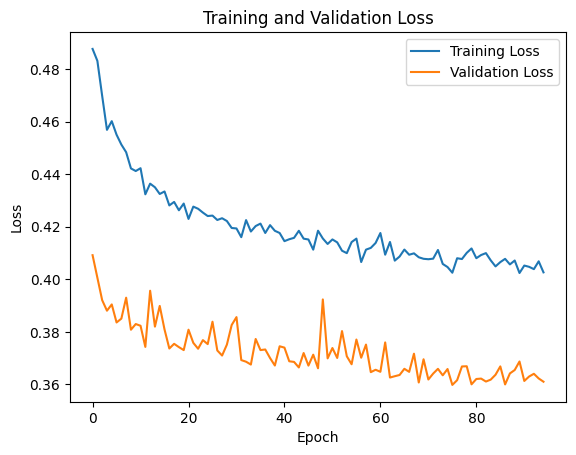

In [38]:
history=best_model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

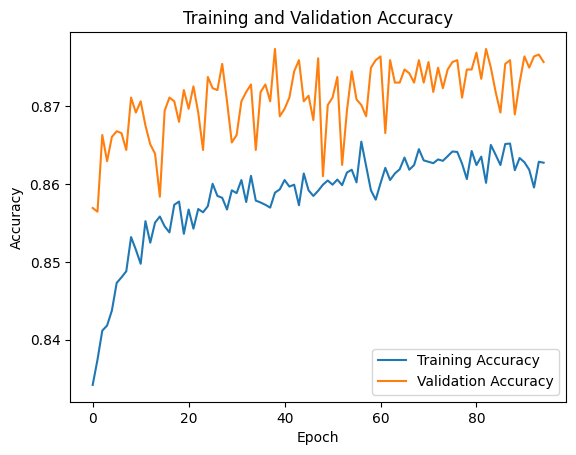

In [39]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5. Making Final Prediction and Submission File

In [40]:
pred=best_model.predict(test)
pred

433/433 [==============================] - 1s 2ms/step


array([[8.9963148e-11, 3.3103536e-08, 3.1837686e-03, ..., 5.6131161e-05,
        3.5294092e-06, 1.2546701e-04],
       [1.3043215e-03, 3.3745434e-02, 1.9989669e-02, ..., 5.3927317e-07,
        8.4386015e-01, 1.0109491e-01],
       [6.3260903e-11, 1.4893755e-08, 9.2120678e-04, ..., 9.9659514e-01,
        1.5372588e-06, 2.6040265e-05],
       ...,
       [9.5719606e-01, 4.0413626e-02, 1.0959944e-06, ..., 4.3062562e-09,
        2.3267628e-03, 6.2407700e-05],
       [2.9928148e-01, 6.9597870e-01, 4.6935162e-05, ..., 5.2412661e-11,
        4.4565853e-03, 2.3620547e-04],
       [7.4324519e-11, 4.8771454e-08, 3.0137396e-03, ..., 5.3636613e-05,
        3.0798549e-06, 1.3453877e-04]], dtype=float32)

In [41]:
y_pred_final=best_model.predict(test).argmax(axis=1)
y_pred_final

433/433 [==============================] - 1s 2ms/step


array([3, 5, 4, ..., 0, 1, 3])

In [42]:
y_submission = pd.DataFrame(y_pred_final, columns=['NObeyesdad'])
y_submission

,NObeyesdad
0,3
1,5
2,4
3,2
4,4
...,...
13835,6
13836,1
13837,0
13838,1


In [43]:
y_final = le.inverse_transform(y_submission)
y_final

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

In [44]:
y_final = pd.DataFrame(y_final)
submission_to_do = pd.concat([id, y_final], axis = 1)
submission_to_do.to_csv('submission.csv', index = False)

Check my other notebooks on this competition :

https://www.kaggle.com/code/smitraval24/eda-baseline-xgb-lgbm-catboost-pipelines

https://www.kaggle.com/code/smitraval24/91-easy-automl-autogluon